# <font size='6' color='darkorange' face='Courier New'>**Online Retail II**</font>
<hr style="color: grey; border-style: solid; border-width: 2px; font-weight: bold;">

<font size='5' face='Courier New'>**План выполнения проекта**</font>

- 1. Загрузка данных и предобработка 

- 2. Customer Lifetime Value

- 3. Customer Lifetime Value Prediction
  - 3.1 Model BG-NBD
  - 3.2 Gamma-Gamma Submodel

- 4. Алгоритмы кластеризации
  - 4.1 K-Means
  - 4.2 Means Shift
  - 4.3 Выводы по алгоритмам кластеризации

## 1.Загрузка данных и предобработка

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt
plt.style.use ('dark_background')
import seaborn as sns

from lifetimes import BetaGeoFitter
from scipy.special import logsumexp
from lifetimes import GammaGammaFitter

from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# чтение файла с данными
df = pd.read_csv('C:/П.А/SQL & Python/1. Python/DB/Online_Retail_DataSet.csv', encoding = 'unicode_escape')

Предобработку выполним как в `Online Retail I`

In [3]:
# приведем название столбцов к нижнему регистру
df = df.rename(columns = str.lower)

In [4]:
# переименуем название колонок, добавим нижнее
df.rename(index = str, columns = {'invoiceno': 'invoice_no',
                                  'stockcode' : 'stock_code',
                                  'invoicedate' : 'invoice_date',
                                  'unitprice' : 'unit_price',
                                  'customerid' : 'cust_id'}, inplace = True)

In [5]:
# приведем содержание столбца к нижнему регистру
df['description'] = df.description.str.lower()

In [6]:
df.sample(1)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,cust_id,country
297808,562955,21811,hanging heart with bell,10,11-08-2011 10:14,2.46,NaN,United Kingdom


In [7]:
# удаляем пропущенных значений в датасете
df.dropna(inplace = True)
df.isnull().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
cust_id         0
country         0
dtype: int64

In [8]:
df.shape

(406829, 8)

In [9]:
# удаляем все отмененные заказы
df = df[df['invoice_no'].str.startswith('C') != True]

In [10]:
# удаляем дубликаты
df.drop_duplicates(inplace = True)

In [11]:
# изменяем тип данных на int
df['cust_id'] = df['cust_id'].astype('int64')

In [12]:
# преобразует колонку из текста в дату
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format = '%d-%m-%Y %H:%M')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    392732 non-null  object        
 1   stock_code    392732 non-null  object        
 2   description   392732 non-null  object        
 3   quantity      392732 non-null  int64         
 4   invoice_date  392732 non-null  datetime64[ns]
 5   unit_price    392732 non-null  float64       
 6   cust_id       392732 non-null  int64         
 7   country       392732 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.0+ MB


In [14]:
df.drop(df[df['quantity'] > 10000].index, inplace = True)

In [15]:
df.drop(df[df['unit_price'] > 3000].index, inplace = True)

In [16]:
df[['quantity', 'unit_price', 'cust_id']].describe()

,quantity,unit_price,cust_id
count,392724.000000,392724.000000,392724.000000
mean,12.726829,3.065634,15287.762594
std,43.086921,13.150890,1713.558231
min,1.000000,0.000000,12347.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,4800.000000,2500.000000,18287.000000


In [17]:
df.drop(df[df['unit_price'] == 0.0].index, inplace = True)

In [18]:
df[df['unit_price'] == 0.0].shape[0]

0

In [19]:
df['amount_price'] = df['quantity'] * df['unit_price']

In [20]:
df = df.reset_index(drop = True)
df.tail(1)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,cust_id,country,amount_price
392684,581587,22138,baking set 9 piece retrospot,3,2011-12-09 12:50:00,4.95,12680,France,14.85


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392685 entries, 0 to 392684
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    392685 non-null  object        
 1   stock_code    392685 non-null  object        
 2   description   392685 non-null  object        
 3   quantity      392685 non-null  int64         
 4   invoice_date  392685 non-null  datetime64[ns]
 5   unit_price    392685 non-null  float64       
 6   cust_id       392685 non-null  int64         
 7   country       392685 non-null  object        
 8   amount_price  392685 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 27.0+ MB


## 2.Customer Lifetime Value

**Определение CLV**

**CLV** – это показатель того, насколько ценен клиент для вашей компании, причем не только на основе каждой покупки, но и в целом.

**Пожизненная ценность клиента** — метрика, используемая для оценки прибыли, которую компания может получить от своего клиента за время его пользования продуктами. Это важный показатель, поскольку удержание существующих клиентов обходится дешевле, чем привлечение новых, поэтому увеличение ценности существующих клиентов — отличный способ стимулировать рост. Пренебрежение CLV может привести к чрезмерным инвестициям в краткосрочных клиентов, которые могут совершить лишь одну покупку.

Знание CLV помогает предприятиям разрабатывать стратегии по привлечению новых клиентов и удержанию существующих, сохраняя при этом норму прибыли.

**Как посчитать CLTV?**

Универсальной методологии не существует, потребуется заточить концепцию под ваш бизнес.

**Формулы:**

- **Ценность клиента** = частота покупок * средняя стоимость заказа
- **CLTV** = ((ценность клиента / коэффициент оттока) * маржа прибыли)
- **Ценность клиента** = средняя стоимость заказа * частота покупок
- **Средняя стоимость заказа** = общая цена / общая сумма транзакции
- **Частота покупок** = общая сумма транзакций / общее количество клиентов
- **Частота повторения** = общее количество клиентов, совершивших несколько покупок / общее количество клиентов.
- **Уровень оттока** = 1 – частота повторения
- **Размер прибыли** = общая цена * 0,10


**Параметры:**

- **Customer Value** (Ценность клиента): показатель, отражающий вклад клиента в бизнес на протяжении всей его жизни. Обычно он рассчитывается путем умножения средней стоимости заказа на частоту покупок.

- **Churn Rate** (Уровень оттока): Скорость, с которой клиенты покидают бизнес в течение определенного периода. Обычно оно выражается в процентах.

- **Profit Margin** (Маржа прибыли): указывает процент прибыли от продажи продукта или услуги. Маржа прибыли отражает разницу между общим доходом и общими затратами.

- **Average Order Value** (Средняя стоимость заказа): представляет собой среднюю сумму денег, которую клиент тратит во время средней транзакции. Он рассчитывается путем деления общего дохода на общее количество транзакций.

- **Purchase Frequency** (Частота покупок): рассчитывается путем деления общего количества транзакций за определенный период на общее количество клиентов. Он показывает, как часто средний клиент совершает покупку.

- **Total Price:** (Общая цена): представляет собой общий доход, полученный за определенный период.

- **Total Transaction** (Всего транзакций): общее количество транзакций, произошедших за определенный период.

- **Total Number of Customers** (Общее количество клиентов): общее количество клиентов, которые взаимодействовали с компанией в течение определенного периода.

- **Repeat Rate** (Коэффициент повторения): процент клиентов, которые повторно посещают компанию или совершают повторные покупки в течение определенного периода.

In [22]:
# создаем копию
cltv = df.copy()

In [23]:
# вычисляем несколько агрегированных метрик для каждого уникального значения 'cust_id'
cltv = df.groupby('cust_id').agg(total_transaction = ('invoice_no', 'nunique'),
                                 total_unit = ('quantity', 'sum'), 
                                 total_price = ('amount_price', 'sum'))
cltv.head()

,total_transaction,total_unit,total_price
cust_id,,,
12347,7,2458,4310.00
12348,4,2341,1797.24
12349,1,631,1757.55
12350,1,197,334.40
12352,8,536,2506.04


**Расчет средней стоимости заказа**

In [24]:
cltv['average_order_value'] = cltv['total_price'] / cltv['total_transaction']

In [25]:
cltv.head(1)

,total_transaction,total_unit,total_price,average_order_value
cust_id,,,,
12347,7,2458,4310.0,615.714286


**Расчет частоты покупок**

In [26]:
cltv['purchase_frequency'] = cltv['total_transaction'] / cltv.shape[0]

In [27]:
cltv.head(1)

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency
cust_id,,,,,
12347,7,2458,4310.0,615.714286,0.001614


**Расчет частоты повторений и оттока клиентов**

Если у клиента есть более одной транзакции, это означает более одной покупки. Причина, по которой мы фокусируемся на нескольких покупках, заключается в том, что у покупателя должна быть метка `наш клиент`.

In [28]:
repeat_rate = cltv[cltv['total_transaction'] > 1].shape[0] / cltv.shape[0]

churn_rate = 1 - repeat_rate

print(churn_rate)

0.34447774959649524


In [29]:
cltv.head(1)

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency
cust_id,,,,,
12347,7,2458,4310.0,615.714286,0.001614


**Расчет размер прибыли**

In [30]:
cltv['profit_margin'] = cltv['total_price'] * 0.10

In [31]:
cltv.head(1)

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin
cust_id,,,,,,
12347,7,2458,4310.0,615.714286,0.001614,431.0


**Расчет ценности клиента**

In [32]:
cltv['customer_value'] = cltv['average_order_value'] * cltv["purchase_frequency"]

In [33]:
cltv.head(1)

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value
cust_id,,,,,,,
12347,7,2458,4310.0,615.714286,0.001614,431.0,0.993774


**Расчет пожизненной ценности клиента**

In [34]:
cltv['customer_lifetime_value'] = (cltv['customer_value'] / churn_rate) * cltv['profit_margin']

'''cltv_df.sort_values - этот метод используется для сортировки данных внутри df. 
Он сортирует данные в df с помощью функции sort_values.
by = 'customer_lifetime_value' - параметр by указывает, какой столбец использовать для сортировки. 
В этом случае сортировка осуществляется по столбцу 'customer_lifetime_value'.
ascending = False -  этот параметр гарантирует, что сортировка выполняется в порядке убывания, 
при этом самые высокие значения 'customer_lifetime_value' появляются вверху'''

cltv.sort_values(by = 'customer_lifetime_value', ascending = False).head(5)

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,customer_lifetime_value
cust_id,,,,,,,,
14646,73,196915,280206.02,3838.438630,0.016832,28020.602,64.608259,5.255382e+06
18102,60,64124,259657.30,4327.621667,0.013834,25965.730,59.870256,4.512846e+06
17450,46,69973,194390.79,4225.886739,0.010606,19439.079,44.821487,2.529302e+06
14911,201,80240,143711.17,714.980945,0.046345,14371.117,33.136078,1.382390e+06
12415,21,77374,124914.53,5948.310952,0.004842,12491.453,28.802059,1.044420e+06


In [35]:
cltv_rounded = cltv.round(2)

In [36]:
cltv_rounded.describe().T

,count,mean,std,min,25%,50%,75%,max
total_transaction,4337.0,4.271616,7.696983,1.00,1.00,2.00,5.00,209.00
total_unit,4337.0,1152.129813,4769.075734,1.00,159.00,378.00,988.00,196915.00
total_price,4337.0,1987.084517,8527.253617,2.90,306.45,668.43,1657.28,280206.02
average_order_value,4337.0,380.338061,496.916404,2.90,177.80,291.88,428.00,14844.77
purchase_frequency,4337.0,0.000228,0.001877,0.00,0.00,0.00,0.00,0.05
profit_margin,4337.0,198.708663,852.725352,0.29,30.64,66.84,165.73,28020.60
customer_value,4337.0,0.458204,1.966191,0.00,0.07,0.15,0.38,64.61
customer_lifetime_value,4337.0,5130.240507,116890.649672,0.00,6.29,29.91,183.84,5255382.44


**Вывод:**

Рассматривая клиента с наивысшим показателем CLTV, мы обнаруживаем, что общая стоимость товаров (total_price) и прибыль (profit_margin) достигают своих максимальных значений. Исходя из этого, можно сделать вывод о значительном влиянии этих переменных на величину CLTV.

Проведем еще один анализ.

**Создание и анализ сегментов CLTV**

In [37]:
'''воспользуемся методом qcut, чтобы добиться более равномерного распределения сегментов,
qcut разделяет данные на квантили, гарантируя равное количество пользователей в каждом интервале.'''

cltv['segment'] = pd.qcut(cltv['customer_lifetime_value'], 4, labels = ['D', 'C', 'B', 'A'])

cltv.sort_values(by = 'customer_lifetime_value', ascending = False).head(3)

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,customer_lifetime_value,segment
cust_id,,,,,,,,,
14646,73,196915,280206.02,3838.438630,0.016832,28020.602,64.608259,5.255382e+06,A
18102,60,64124,259657.30,4327.621667,0.013834,25965.730,59.870256,4.512846e+06,A
17450,46,69973,194390.79,4225.886739,0.010606,19439.079,44.821487,2.529302e+06,A


In [38]:
cltv.groupby('segment').agg({'count', 'mean', 'sum'})

total_transaction                total_unit                  
                     mean    sum count         mean      sum count   
segment                                                              
D                1.260829   1368  1085   116.493088   126395  1085  \
C                1.878229   2036  1084   285.121771   309072  1084   
B                3.516605   3812  1084   646.887454   701226  1084   
A               10.433579  11310  1084  3560.972325  3860094  1084   

         total_price                    average_order_value                  
                mean          sum count                mean            sum   
segment                                                                      
D         177.753751   192862.820  1085          154.067714  167163.469762  \
C         461.572585   500344.682  1084          301.840097  327194.665333   
B        1065.270444  1154753.161  1084          395.792081  429038.616346   
A        6245.410416  6770024.891  1084          669.861201  726129.541534   

              purchase_frequency                 profit_margin                
        count               mean       sum count          mean          sum   
segment                                                                       
D        1085           0.000291  0.315425  1085     17.775375   19286.2820  \
C        1084           0.000433  0.469449  1084     46.157258   50034.4682   
B        1084           0.000811  0.878949  1084    106.527044  115475.3161   
A        1084           0.002406  2.607793  1084    624.541042  677002.4891   

              customer_value                    customer_lifetime_value   
        count           mean          sum count                    mean   
segment                                                                   
D        1085       0.040985    44.469177  1085                2.463490  \
C        1084       0.106427   115.366540  1084               15.059938   
B        1084       0.245624   266.256205  1084               81.243538   
A        1084       1.440030  1560.992596  1084            20426.925479   

                             
                  sum count  
segment                      
D        2.672886e+03  1085  
C        1.632497e+04  1084  
B        8.806799e+04  1084  
A        2.214279e+07  1084

In [40]:
plt.style.use('default')

In [41]:
plt.style.use ('dark_background')

Text(0, 0.5, 'Пожизненная ценность клиента')

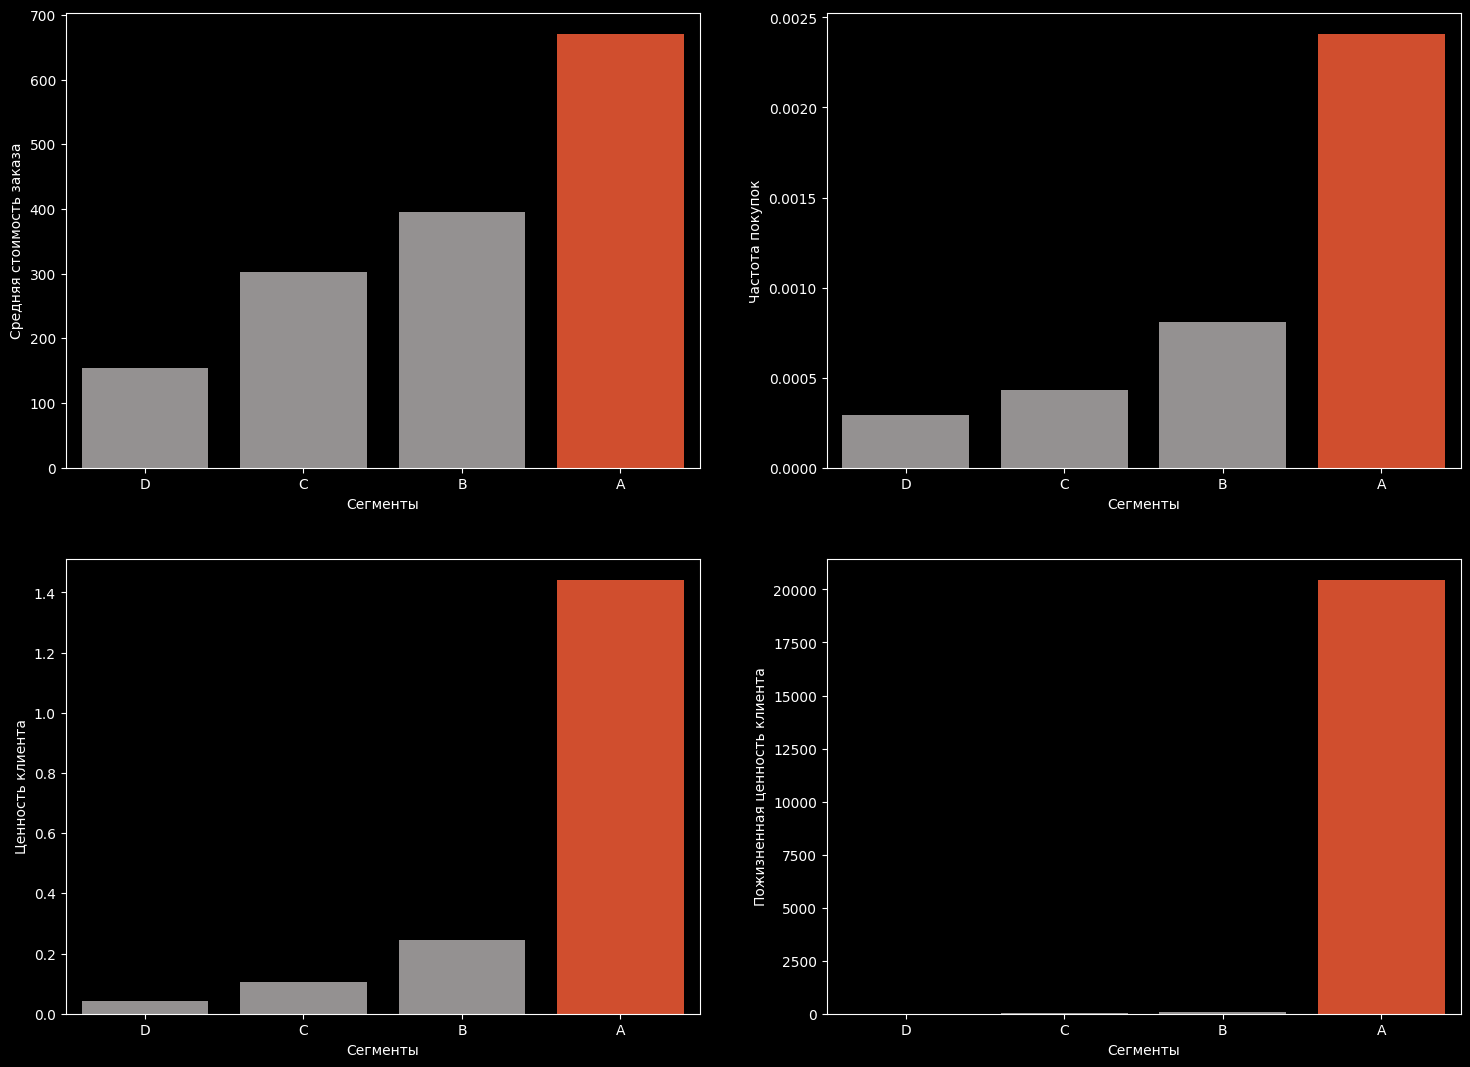

In [42]:
# устанавливаем размер фигуры
plt.figure(figsize = (18, 13))

# cоздаем цветовую палитру
unique_segments = cltv['segment'].unique()
colors = {seg: '#949191' if seg in ['D', 'B', 'C'] else '#eb3e13' for seg in unique_segments}

# строим 4 subplot
plt.subplot(221)
sns.barplot(x = 'segment', y = 'average_order_value', data = cltv, palette = colors, ci = None)
plt.xlabel('Сегменты')
plt.ylabel('Средняя стоимость заказа')

plt.subplot(222)
sns.barplot(x = 'segment', y = 'purchase_frequency', data = cltv, palette = colors, ci = None)
plt.xlabel('Сегменты')
plt.ylabel('Частота покупок')

plt.subplot(223)
sns.barplot(x = 'segment', y = 'customer_value', data = cltv, palette = colors, ci = None)
plt.xlabel('Сегменты')
plt.ylabel('Ценность клиента')

plt.subplot(224)
sns.barplot(x = 'segment', y = 'customer_lifetime_value', data = cltv, palette = colors, ci = None)
plt.xlabel('Сегменты')
plt.ylabel('Пожизненная ценность клиента')

**Выводы**

Существуют ряд способов повысить CLTV:

- Один из способов увеличить CLTV — повышать удовлетворенность клиентов. Узнать, чем клиенты не довольны, чем можно дополнить продукт. Как миниму собирать отзывы.

- Увеличивать срок, пока пользователь будет оставаться клиентом компании, помогают программы лояльности. Различные скидки или начисляет баллы за покупки затем клиент можно получить товар бесплатно.

- Рассылка полезных материалов по email — удобный способ напомнить пользователям о товарах компании. Проанализировать доходят ли письма, читают ли клиенты этот материал. 

## 3.Customer Lifetime Value  Prediction

Очень важно предсказать будущее разрабатываемых стратегий.
Оценим пожизненную ценность клиента с помощью временной проекции, условной и вероятностной. Условный означает индивидуальный подход, вероятностный означает использование вероятностных моделей. Оценка будет основана на формуле расчета ценности клиента, как указано выше.

Выполним план работы в 4 шага

1. Подготовка данных
2. Рассчитаем прогнозные значения ожидаемых продаж с помощью модели BG-NBD.
3. Рассчитаем значения ожидаемой средней прибыли с помощью модели Gamma-Gamma.
4. Рассчитаем CLTV за определенный период времени с помощью моделей BG-NBD и Gamma-Gamma.

**Формула CLTV predicrion**

**Customer Lifetime Value = Expected Number of Transaction * Expected Average Profit**

**Customer Lifetime Value predicrion = BG/NBD Model * Gamma Gamma Submodel**

**Expected Number of Transaction** (Ожидаемое количество транзакций)

- Смоделируем покупательское поведение всех клиентов с помощью распределения вероятностей, а затем адаптируем смоделированное нами поведение к индивидуальному, чтобы оценить ожидаемое количество покупок для каждого человека.

**Expected Average Profit** (Ожидаемая средняя прибыль)
- Сделаем оценку ожидаемой средней прибыли для каждого человека, формируя поведение, которое мы смоделировали лично.

Рассчитаем ожидаемое количество транзакций и средние значения прибыли для каждого человека, исходя из распределения клиентов, которое мы определили индивидуально.
Использовать модель `BG/NBD` для оценки количества транзакций и подмодель `Gamma-Gamma` для оценки средней прибыли.


**Подготовка данных**

In [43]:
# создаем копию
cltv_pred = df.copy()

In [44]:
cltv_pred = cltv_pred.loc[:, ['invoice_date', 'invoice_no', 'cust_id', 'amount_price']]
cltv_pred .head(2)

,invoice_date,invoice_no,cust_id,amount_price
0,2010-12-01 08:26:00,536365,17850,15.30
1,2010-12-01 08:26:00,536365,17850,20.34


In [45]:
cltv_pred  = cltv_pred.query('invoice_date >= "2010-12-01" & invoice_date <= "2011-12-31"')
cltv_pred.head(5)

,invoice_date,invoice_no,cust_id,amount_price
0,2010-12-01 08:26:00,536365,17850,15.30
1,2010-12-01 08:26:00,536365,17850,20.34
2,2010-12-01 08:26:00,536365,17850,22.00
3,2010-12-01 08:26:00,536365,17850,20.34
4,2010-12-01 08:26:00,536365,17850,20.34


Поскольку будут использоваться такие параметры, как новизна и возраст клиента, установим дату как в RFM.

In [46]:
cltv_pred_fday= cltv_pred .invoice_date.max() + dt.timedelta(days = 1)
cltv_pred_fday

Timestamp('2011-12-10 12:50:00')

In [48]:
# группируме данные по cust_id и применяем агрегирование к выбранным столбцам
p_cltv = cltv_pred.groupby('cust_id').agg(
                            {'invoice_date': [lambda date: (date.max() - date.min()).days,
                                              lambda date: (cltv_pred_fday - date.min()).days],
                              'invoice_no': lambda num: num.nunique(),
                              'amount_price': lambda amount_price: amount_price.sum()})

p_cltv.columns = p_cltv.columns.droplevel(0)

# 'T' - это временной период, в течение которого клиент не совершил покупки, но его активность не забыта. 
p_cltv.columns = ['recency', 'T', 'frequency', 'monetary']
p_cltv.head()

,recency,T,frequency,monetary
cust_id,,,,
12347,365,367,7,4310.00
12348,282,358,4,1797.24
12349,0,19,1,1757.55
12350,0,310,1,334.40
12352,260,297,8,2506.04


Рассчитали денежную стоимость как общую сумму `amount_price`.

Теперь выразим денежную стоимость как средний заработок на покупку.

In [49]:
p_cltv['monetary'] = p_cltv['monetary'] / p_cltv['frequency']

# выбор денежных значений больше нуля
p_cltv = p_cltv[p_cltv['monetary'] > 0]

# недавность и T, выраженные в недельном выражении для BGNBD
p_cltv['recency'] = p_cltv['recency'] / 7
p_cltv['T'] = p_cltv['T'] / 7

# выбор частот больше 1
p_cltv = p_cltv[(p_cltv['frequency'] > 1)]
p_cltv.head()

,recency,T,frequency,monetary
cust_id,,,,
12347,52.142857,52.428571,7,615.714286
12348,40.285714,51.142857,4,449.310000
12352,37.142857,42.428571,8,313.255000
12356,43.142857,46.571429,3,937.143333
12358,21.285714,21.571429,2,584.030000


### 3.1 BG-NBD

**Модель BG-NBD**

Бета-геометрическое/отрицательное биномиальное распределение, известное как модель BG-NBD. Иногда ее также называют `Покупай, пока не умрешь`. Она дает нам условное ожидаемое количество сделок в следующем периоде. Эта модель может ответить на следующие вопросы:

- Сколько сделок будет на следующей неделе?
- Сколько транзакций будет в ближайшие 3 месяца?
- Какие клиенты совершат больше всего покупок в ближайшие 2 недели?

Эта модель моделирует 2 процесса, используя вероятность для прогнозирования ожидаемого количества сделок

- Процесс транзакций (покупка)
- Процесс отсева (пока не умрете)

**Процесс транзакции (покупка)**
- Используется для обозначения процесса покупки
- Пока клиент жив, количество покупок, совершенных клиентом, будет распределяться ядом по параметру скорости транзакций
- Пока клиент жив, он будет совершать покупки в соответствии со своей скоростью транзакций
- Скорость транзакций будет меняться для каждого покупателя, и она будет распределена гамма (r,α)

**Процесс отсева (пока не умрете)**
- Это означает прекращение покупок.
- Каждый клиент имеет свой коэффициент отсева с вероятностью p
- Клиент будет отсеян с вероятностью p
- Коэффициенты отсева будут меняться для каждого покупателя, и они будут распределены бета (a,b) для массы

**Формула BG-NBD**

$E(Y(t)|X = x, t_x, T, r, \alpha, a, b)=\frac{a + b + x - 1}{a-1} X \frac{ \left[1 - \left(\frac{\alpha + T}{\alpha + T + t} \right)^{r+x} 2F_1(r + x, b + x; a + b + x - 1; \frac{t}{\alpha + T + t} \right]}
{1 + \partial_{(x>0)} \frac{\alpha}{b + x -1}
\left( \frac{\alpha + T}{alpha + t_x}   \right)^{r+x}    } $

Параметры:
- `E` - означает ожидаемое значение
- `|` - означает, что эта вероятность является условной (условное ожидаемое количество сделок)
- `x` - означает частоту для каждого покупателя, который совершил покупку не менее 2 раз.
- `tx` - означает периодичность для каждого покупателя. В данном случае мы предположим, что периодичность будет исчисляться неделями. Время от даты последней покупки до даты первой покупки (недели).
- `T` - означает время от сегодняшней даты до последней даты покупки (недели).
- `r,α` - берется из гамма-распределения (процесс 'покупки'). Скорость транзакций в массе.
- `a,b` - происходит из бета-распределения (процесс 'пока не умрешь'). Коэффициент выбытия массы.
- `Y(t)` - ожидаемое количество транзакций для каждого покупателя.

In [50]:
'''penalizer_coef - параметр, используется для регуляризации модели, 
чтобы снизить переобучение и улучшить ее обобщающую способность.
0.001 - коэффициентом регуляризации.'''

bgf = BetaGeoFitter(penalizer_coef = 0.001)

bgf.fit(p_cltv['frequency'],
        p_cltv['recency'],
        p_cltv['T'])

<lifetimes.BetaGeoFitter: fitted with 2843 subjects, a: 0.12, alpha: 11.37, b: 2.48, r: 2.18>

In [51]:
# ожидаемая покупка (транзакция) через 1 неделю
p_cltv["expected_purc_1_week"] = bgf.predict(1,
                                               p_cltv['frequency'],
                                               p_cltv['recency'],
                                               p_cltv['T'])

p_cltv.sort_values("expected_purc_1_week", ascending = False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week
cust_id,,,,,
12748,53.142857,53.428571,209,158.149234,3.251279
14911,53.142857,53.285714,201,714.980945,3.136607
17841,53.000000,53.285714,124,326.772903,1.946500
13089,52.285714,52.857143,97,605.794639,1.538262
14606,53.142857,53.285714,93,129.851075,1.468429
15311,53.285714,53.428571,91,666.293956,1.434370
12971,52.571429,53.142857,86,130.115233,1.361536
14646,50.428571,50.714286,73,3838.438630,1.207024
13408,53.000000,53.428571,62,453.500645,0.986705


In [52]:
# ожидаемая покупка через 1 месяц
p_cltv['expected_purc_1_month'] = bgf.predict(4,
                                               p_cltv['frequency'],
                                               p_cltv['recency'],
                                               p_cltv['T'])

p_cltv.sort_values('expected_purc_1_month', ascending = False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
cust_id,,,,,,
12748,53.142857,53.428571,209,158.149234,3.251279,12.970758
14911,53.142857,53.285714,201,714.980945,3.136607,12.513207
17841,53.000000,53.285714,124,326.772903,1.946500,7.765349
13089,52.285714,52.857143,97,605.794639,1.538262,6.136603
14606,53.142857,53.285714,93,129.851075,1.468429,5.858113
15311,53.285714,53.428571,91,666.293956,1.434370,5.722271
12971,52.571429,53.142857,86,130.115233,1.361536,5.431641
14646,50.428571,50.714286,73,3838.438630,1.207024,4.814734
13408,53.000000,53.428571,62,453.500645,0.986705,3.936329


Есть один важный момент. Эта модель работает на основе недель. Поэтому нам нужно передать аргумент времени (первый аргумент в функции), основанный на неделях.

In [53]:
# ожидаемая покупка через 3 месяц
p_cltv['expected_purc_3_month'] = bgf.predict(4 *3,
                                               p_cltv['frequency'],
                                               p_cltv['recency'],
                                               p_cltv['T'])

p_cltv.sort_values('expected_purc_3_month', ascending = False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month
cust_id,,,,,,,
12748,53.142857,53.428571,209,158.149234,3.251279,12.970758,38.653115
14911,53.142857,53.285714,201,714.980945,3.136607,12.513207,37.289070
17841,53.000000,53.285714,124,326.772903,1.946500,7.765349,23.140312
13089,52.285714,52.857143,97,605.794639,1.538262,6.136603,18.285842
14606,53.142857,53.285714,93,129.851075,1.468429,5.858113,17.456694
15311,53.285714,53.428571,91,666.293956,1.434370,5.722271,17.052114
12971,52.571429,53.142857,86,130.115233,1.361536,5.431641,16.185572
14646,50.428571,50.714286,73,3838.438630,1.207024,4.814734,14.343687
13408,53.000000,53.428571,62,453.500645,0.986705,3.936329,11.729886


In [54]:
# ожидаемая покупка через 6 месяц
p_cltv['expected_purc_6_month'] = bgf.predict(4 *6,
                                               p_cltv['frequency'],
                                               p_cltv['recency'],
                                               p_cltv['T'])

p_cltv.sort_values('expected_purc_6_month', ascending = False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month
cust_id,,,,,,,,
12748,53.142857,53.428571,209,158.149234,3.251279,12.970758,38.653115,76.601532
14911,53.142857,53.285714,201,714.980945,3.136607,12.513207,37.289070,73.896983
17841,53.000000,53.285714,124,326.772903,1.946500,7.765349,23.140312,45.857302
13089,52.285714,52.857143,97,605.794639,1.538262,6.136603,18.285842,36.234937
14606,53.142857,53.285714,93,129.851075,1.468429,5.858113,17.456694,34.593640
15311,53.285714,53.428571,91,666.293956,1.434370,5.722271,17.052114,33.792437
12971,52.571429,53.142857,86,130.115233,1.361536,5.431641,16.185572,32.074005
14646,50.428571,50.714286,73,3838.438630,1.207024,4.814734,14.343687,28.415173
13408,53.000000,53.428571,62,453.500645,0.986705,3.936329,11.729886,23.244792


Общее количество транзакций, ожидаемых в течение следующих 6 месяцев.

In [55]:
bgf.predict(4 *6, 
                p_cltv['frequency'], 
                p_cltv['recency'], 
                p_cltv['T']).sum()

10429.06222530651

### 8.2 Gamma-Gamma субмодель

Используем эту модель для прогнозирования того, сколько средней прибыли мы можем получить для каждого клиента. Она дает нам ожидаемую среднюю прибыль для каждого клиента после моделирования средней прибыли для всей массы.

- Денежная стоимость клиента (сумма его транзакций) будет случайным образом распределена вокруг среднего значения его транзакций.
- Среднее значение транзакций может меняться в периоды между клиентами, но оно не меняется для одного клиента.
- Среднее значение транзакций будет распределено гамма между всеми клиентами



**Формула Gamma-Gamma**

$E(M|p, q, \gamma, m_x, x) =
\frac{(\gamma + m_xx)p}{px + q -1} =
\left( \frac {q-1}{px + q - 1} \right)
\frac{\gamma p}{q - 1} + \left( \frac{px}{px + q -1} \right)
m_x$

Параметры:

- `E` означает ожидаемое значение
- `x` означает частоту для каждого клиента
- `mx` - денежное выражение для каждого клиента.
- `M` обозначает ожидаемую стоимость сделок (ожидаемая средняя прибыль)
- `p,q,γ` происходит из гамма-распределения

In [56]:
gam = GammaGammaFitter(penalizer_coef = 0.01)
gam.fit(p_cltv['frequency'], 
        p_cltv['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2843 subjects, p: 3.79, q: 0.34, v: 3.72>

In [57]:
# ожидаемая средняя прибыль
p_cltv['expected_average_profit'] = gam.conditional_expected_average_profit(p_cltv['frequency'],
                                                                            p_cltv['monetary'])

p_cltv.sort_values('expected_average_profit', ascending = False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_average_profit
cust_id,,,,,,,,,
15749,13.857143,47.428571,3,14844.766667,0.028476,0.113542,0.337915,0.668579,15761.600014
15098,0.000000,26.000000,3,13305.500000,0.010336,0.041140,0.121953,0.240172,14127.402741
12415,44.714286,48.285714,21,5948.310952,0.379876,1.515061,4.511868,8.933966,5998.265341
12590,0.000000,30.142857,2,4932.130000,0.011784,0.046922,0.139210,0.274417,5404.952735
16000,0.000000,0.428571,3,4131.233333,0.423153,1.668682,4.859258,9.409852,4387.335023
18102,52.285714,52.428571,60,4327.621667,0.971540,3.875670,11.547983,22.881481,4340.290109
12435,26.857143,38.285714,2,3914.945000,0.076395,0.304409,0.904606,1.786581,4290.675061
17450,51.285714,52.571429,46,4225.886739,0.747853,2.983332,8.889142,17.613123,4242.038570
14088,44.571429,46.000000,13,3883.985385,0.261202,1.041598,3.100791,6.137202,3937.049519


**Прогнозирование CLTV с помощью моделей BG-NBD и Gamma-Gamma**

Ожидаемая пожизненная стоимость клиентов в ближайшие 3 месяца.

In [58]:
p_cltv['cltv_pred_3_months'] = gam.customer_lifetime_value(bgf, 
                                                           p_cltv['frequency'], 
                                                           p_cltv['recency'], 
                                                           p_cltv['T'], 
                                                           p_cltv['monetary'],
# месяц                                               
                                                           time = 3,
# информация о частоте T. В этом случае мы устанавливаем неделю, используя «W».                                      
                                                           freq = 'W',
# ставка discount, которую компания может применять время от времени
                                                           discount_rate = 0.01) 

In [61]:
p_cltv.sort_values(by = 'cltv_pred_3_months', ascending = False).head(11)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv_pred_3_months
cust_id,,,,,,,,,,
14646,50.428571,50.714286,73,3838.438630,1.207024,4.814734,14.343687,28.415173,3847.675047,58722.816870
18102,52.285714,52.428571,60,4327.621667,0.971540,3.875670,11.547983,22.881481,4340.290109,53331.092798
17450,51.285714,52.571429,46,4225.886739,0.747853,2.983332,8.889142,17.613123,4242.038570,40122.678625
14096,13.857143,14.571429,17,3833.222941,0.729647,2.899599,8.566228,16.809128,3873.146313,35270.884130
12415,44.714286,48.285714,21,5948.310952,0.379876,1.515061,4.511868,8.933966,5998.265341,28794.643758
14911,53.142857,53.285714,201,714.980945,3.136607,12.513207,37.289070,73.896983,715.619924,28393.932494
14156,51.571429,53.142857,55,2131.092364,0.878018,3.502686,10.437313,20.682446,2137.934211,23743.338349
16000,0.000000,0.428571,3,4131.233333,0.423153,1.668682,4.859258,9.409852,4387.335023,22633.443044
17511,52.857143,53.428571,31,2937.496129,0.509084,2.030879,6.051514,11.991344,2954.223759,19022.401332


**Выводы:**

- Есть клиенты с высоким значением новизны и высоким значением CLTV. Согласно одной из теорий **BG-NBD** гласит: "Если клиент с регулярной транзакционной способностью не уходит, вероятность покупки увеличивается по мере увеличения значения давности клиента. Когда клиент совершает покупку, его потребность удовлетворена, на данный момент он становится `частичным оттоком`. Чем дольше он откладывает покупку, тем больше товаров ему требуется приобрести."

- Согласно таблице, те у кого близкие значения `recency` и `T`, находятся в верхней части списка, но было бы неправильно придерживаться только этих двух значений. В конце концов, у других переменных тоже есть коэффициенты.

- Клиенты с высокой и низкой частотой будут классифицироваться как высокопотенциальные клиенты.

Cегментируем наших клиентов, используя их значения CLTV. Эти данные могут быть полезны для принятия мер.

In [62]:
p_cltv['segment'] = pd.qcut(p_cltv['cltv_pred_3_months'],4,['D','C','B','A'])

p_cltv

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_average_profit,cltv_pred_3_months,segment
cust_id,,,,,,,,,,,
12347,52.142857,52.428571,7,615.714286,0.141701,0.565198,1.683526,3.334430,631.979817,1132.042897,A
12348,40.285714,51.142857,4,449.310000,0.092342,0.368272,1.096612,2.171128,470.750306,549.248102,B
12352,37.142857,42.428571,8,313.255000,0.182536,0.727715,2.165092,4.282134,320.706636,738.700815,B
12356,43.142857,46.571429,3,937.143333,0.086204,0.343700,1.022783,2.023354,996.257128,1084.049002,A
12358,21.285714,21.571429,2,584.030000,0.122352,0.486637,1.440212,2.831266,641.816477,982.827916,A
...,...,...,...,...,...,...,...,...,...,...,...
18272,34.857143,35.285714,6,513.096667,0.172169,0.686020,2.038508,4.025804,529.084523,1147.263427,A
18273,36.428571,36.857143,3,68.000000,0.104396,0.415973,1.236051,2.440996,73.511449,96.653185,D
18282,16.857143,18.000000,2,89.025000,0.136560,0.542793,1.604184,3.148964,99.562099,169.795796,D


In [63]:
# анализ 
p_cltv.groupby('segment').agg({'count', 'mean', 'sum'})

recency                              T                       
              mean           sum count       mean           sum count   
segment                                                                 
D        22.230661  15806.000000   711  40.384971  28713.714286   711  \
C        30.717701  21840.285714   711  38.018083  27030.857143   711   
B        29.145875  20693.571429   710  34.567807  24543.142857   710   
A        31.602974  22469.714286   711  34.660438  24643.571429   711   

         frequency                monetary                        
              mean   sum count        mean            sum count   
segment                                                           
D         3.060478  2176   711  184.332480  131060.393610   711  \
C         4.106892  2920   711  273.155552  194213.597474   711   
B         5.439437  3862   710  379.033377  269113.697895   710   
A        11.355837  8074   711  722.995827  514050.032995   711   

        expected_purc_1_week                   expected_purc_1_month   
                        mean         sum count                  mean   
segment                                                                
D                   0.071882   51.108354   711              0.286286  \
C                   0.121866   86.646792   711              0.485295   
B                   0.162855  115.627171   710              0.648144   
A                   0.273388  194.378577   711              1.088456   

                          expected_purc_3_month                      
                sum count                  mean          sum count   
segment                                                              
D        203.549686   711              0.849923   604.295424   711  \
C        345.044770   711              1.440362  1024.097439   711   
B        460.182466   710              1.921403  1364.196165   710   
A        773.892467   711              3.229487  2296.165053   711   

        expected_purc_6_month                    expected_average_profit   
                         mean          sum count                    mean   
segment                                                                    
D                    1.677042  1192.376835   711              199.895267  \
C                    2.841337  2020.190560   711              291.577150   
B                    3.785639  2687.803627   710              400.048729   
A                    6.369467  4528.691204   711              752.381901   

                             cltv_pred_3_months                      
                   sum count               mean           sum count  
segment                                                              
D        142125.534819   711         146.131914  1.038998e+05   711  
C        207311.353973   711         385.624134  2.741788e+05   711  
B        284034.597633   710         695.942962  4.941195e+05   710  
A        534943.531704   711        2354.197089  1.673834e+06   711

**Выводы:**

**CLTV** - используется для определения текущей или потенциальной ценности клиента. Это значение представляет собой расчетную сумму дохода, который клиент, как ожидается, принесет бизнесу. Например, значение CLTV клиента может составлять 500 единиц, что указывает на то, что ожидается, что клиент принесет бизнесу 500 единиц дохода.

**CLTV Prediction** - направлен на прогнозирование будущей ценности для клиентов. Эти прогнозы включают оценку дохода, который, как ожидается, принесет клиент в будущем, на основе его будущих покупательских привычек, лояльности и ожидаемого получения дохода. Прогнозы CLTV также представляют собой оценки доходов, выраженные в определенной валюте или денежной сумме.

**CLTV** и **CLTV Prediction** — это показатели, которые измеряют доход, полученный бизнесом, но они не выражаются напрямую в виде конкретной суммы денег.

- Расчет CLTV представляет собой один период времени. Он представляет временные рамки, в которых проводится анализ.
- Общая цена (`Total Price`) является доминирующим фактором и затмевает влияние частоты покупок(`Purchase Frequency`).
- Если он принес тот же доход, количество транзакций не имеет существенного значения.
- Уровень оттока (`Churn Rate`) — это доход от всей клиентской базы, а не от отдельного человека, что является недостатком.
- Маржинальная прибыль (`Profit Margin`) — это доход от всей клиентской базы, а не от отдельных лиц, что является недостатком.
- Поиск новых клиентов обходится дороже, чем удержание существующего. Можно сравнить результаты по таблице.
- Если смотреть на квартальный анализ, что у клиентов сегмента D показатели продаж ниже единицы. Каковы ценность для компании сегмента D?

## 9.Алгоритмы кластеризации

### 9.1 K-Means

Как работает алгоритм K-средних(**K-means**)?

**Кластеризация** — это процесс разделения всех данных на группы (также известные как кластеры) на основе закономерностей в данных.
K-means является итеративным алгоритмом, который пытается минимизировать сумму квадратов расстояний между объектами и центроидами (средними значениями) кластеров.

Алгоритм k-means работает следующим образом:

1. Выбирается значение k, которое определяет количество кластеров, на которые будет разделен набор данных.
2. Случайным образом выбираются k объектов в качестве начальных центроидов кластеров.
3. Каждый объект из набора данных относится к ближайшему центроиду.
4. Вычисляются новые центроиды, как среднее значение объектов, отнесенных к каждому кластеру.
5. Повторяются шаги 3 и 4 до тех пор, пока центроиды не перестанут изменяться или будет достигнуто максимальное количество итераций.

**Преимущества и недостатки K-Means**

Преимущества:

- Прост в реализации и понимании

- Наличие большого числа модификаций

- Высокая скорость работы и точность на данных сферической формы

Недостатки:

- Низкая точность на данных с несферической формой кластеров

- Чувствительность к начальным значениям центроидов и выбросам

- Необходимость заранее устанавливать число кластеров, что может быть сложно или не оптимально

Повторим операции rfm

In [64]:
# создаем копию
rfm = df.copy()

In [65]:
rfm = df.loc[:, ['invoice_date', 'invoice_no', 'cust_id', 'amount_price']]

In [66]:
rfm  = rfm.query('invoice_date >= "2010-12-01" & invoice_date <= "2011-12-31"')
rfm.head(2)

,invoice_date,invoice_no,cust_id,amount_price
0,2010-12-01 08:26:00,536365,17850,15.30
1,2010-12-01 08:26:00,536365,17850,20.34


In [67]:
final_drfm = rfm .invoice_date.max() + dt.timedelta(days = 1)
final_drfm

Timestamp('2011-12-10 12:50:00')

In [68]:
rfm = df.groupby('cust_id').agg({'invoice_date': lambda x: (final_drfm - x.max()).days,
                                         'invoice_no': 'nunique',
                                         'amount_price': 'sum'})

rfm.rename(columns = {'invoice_date': 'recency', 'invoice_no': 'frequency',
                            'amount_price': 'monetary'}, inplace = True)

rfm.head()

,recency,frequency,monetary
cust_id,,,
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40
12352,36,8,2506.04


In [69]:
# удаляем индекс
rfm = rfm.reset_index(drop=True)
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   recency    4337 non-null   int64  
 1   frequency  4337 non-null   int64  
 2   monetary   4337 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 101.8 KB


In [70]:
rfm.head()

,recency,frequency,monetary
0,2,7,4310.00
1,75,4,1797.24
2,19,1,1757.55
3,310,1,334.40
4,36,8,2506.04


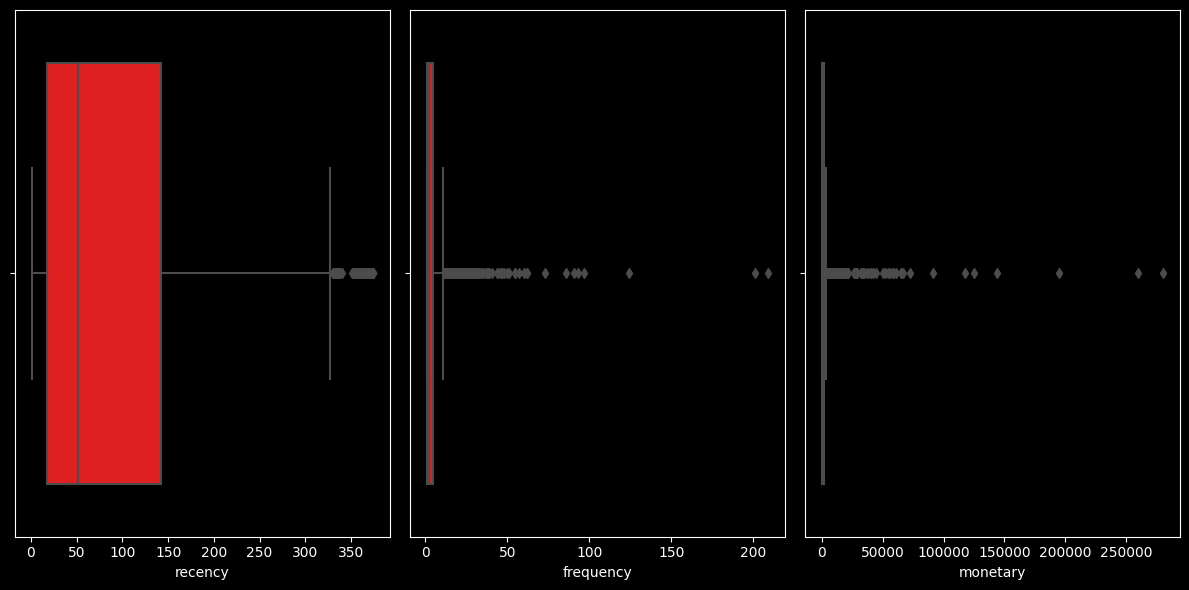

In [71]:
# проверим распределения переменных
column = ['recency','frequency','monetary']

# устанавливаем размер фигуры
fig, axs = plt.subplots(1, 3, figsize = (12, 6))
axs = axs.ravel()

# пройдемся циклом по этому списку
for i, col in enumerate(column):
    sns.boxplot(x = rfm[col], color = 'red', ax = axs[i])

plt.tight_layout()

Удалим выбросы из нашей таблицы

In [72]:
Q1 = rfm.monetary.quantile(0.05)
Q3 = rfm.monetary.quantile(0.95)
IQR = Q3 - Q1

rfm = rfm[(rfm.monetary >= Q1 - 1.5 * IQR) & 
                                    (rfm.monetary <= Q3 + 1.5 * IQR)]

# удаление выбросов для недавности recency
Q1 = rfm.recency.quantile(0.05)
Q3 = rfm.recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.recency >= Q1 - 1.5 * IQR) & 
                                    (rfm.recency <= Q3 + 1.5 * IQR)]

# удаление выбросов для недавности frequency
Q1 = rfm.frequency.quantile(0.05)
Q3 = rfm.frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.frequency >= Q1 - 1.5 * IQR) & (rfm.frequency <= Q3 + 1.5 * IQR)]

In [73]:
rfm.head()

,recency,frequency,monetary
0,2,7,4310.00
1,75,4,1797.24
2,19,1,1757.55
3,310,1,334.40
4,36,8,2506.04


Получили нашу таблицу rfm

In [74]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4261 entries, 0 to 4336
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   recency    4261 non-null   int64  
 1   frequency  4261 non-null   int64  
 2   monetary   4261 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 133.2 KB


In [75]:
# создаем копию
kmeans_algorithm = rfm.copy()

In [76]:
# изменение масштаба атрибутов
standard_scaler = StandardScaler()
df_kmeans_norm = standard_scaler.fit_transform(kmeans_algorithm)

In [77]:
# конвертируем в df
df_kmeans_norm = pd.DataFrame(df_kmeans_norm)
df_kmeans_norm.columns = ['recency','frequency','monetary']
df_kmeans_norm.head()

,recency,frequency,monetary
0,-0.917757,0.872736,1.678414
1,-0.188430,0.095626,0.271262
2,-0.747914,-0.681483,0.249036
3,2.159404,-0.681483,-0.547932
4,-0.578070,1.131773,0.668192


**Метод локтя для определения количества кластеров, которые необходимо сформировать**

In [78]:
plt.style.use('default')

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=10))

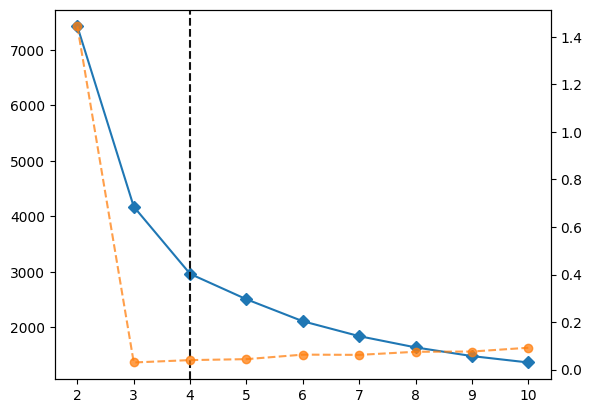

In [79]:
k_means = KMeans()
elbow = KElbowVisualizer(k_means, k=(10))
elbow.fit(df_kmeans_norm)

**Наблюдения:** приведенная выше ячейка указывает на то, что 4 будут оптимальным количеством кластеров для этих данных.

Анализ силуэта для определения количества кластеров, которые необходимо сформировать.

$silhouette score=\frac{p-q}{max(p, q)}$

`p` - это среднее расстояние до точек ближайшего кластера, частью которого точка данных не является.

`q` - среднее внутрикластерное расстояние до всех точек в его собственном кластере.

- Значение диапазона оценки силуэта находится в диапазоне от -1 до 1.

- Оценка ближе к 1 означает, что точка данных очень похожа на другие точки данных в кластере.

- Оценка ближе к -1 указывает на то, что точка данных не похожа на точки данных в своем кластере.

In [80]:
for k in range(2, 11):
    
# kmeans
    kmeans = KMeans(n_clusters = k, max_iter = 50)
    kmeans.fit(df_kmeans_norm)
    cluster_labels = kmeans.labels_
    
# силуэт
    silhouette_avg = silhouette_score(df_kmeans_norm, cluster_labels)
    print('For n_clusters={0}, the silhouette score is {1}'.format(k, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5455686344335404
For n_clusters=3, the silhouette score is 0.5105098964616711
For n_clusters=4, the silhouette score is 0.48551676151414275
For n_clusters=5, the silhouette score is 0.4427630550636715
For n_clusters=6, the silhouette score is 0.4176143158128985
For n_clusters=7, the silhouette score is 0.42096053496041524
For n_clusters=8, the silhouette score is 0.3828726860017152
For n_clusters=9, the silhouette score is 0.38982004892203337
For n_clusters=10, the silhouette score is 0.3506926192584328


**Наблюдения:** Анализ силуэта показывает, что 2,3 или 4 будут наиболее оптимальным количеством кластеров для этого набора данных. Основываясь на методе Elbow, мы будем использовать 4 кластера.

**Окончательная модель KMeans с использованием 4 кластеров**

In [81]:
model_clus4 = KMeans(n_clusters = 4, random_state = 42)
model_clus4.fit(df_kmeans_norm)

kmeans_algorithm['cluster'] = model_clus4.labels_
kmeans_algorithm.groupby('cluster').agg({'recency':'mean',
                                         'frequency':'mean',
                                         'monetary':['mean', 'count']}).round(2)

recency frequency monetary      
           mean      mean     mean count
cluster                                 
0         30.58      7.03  2696.24   795
1        252.50      1.47   428.78  1017
2         51.36      2.29   677.07  2238
3         18.48     15.48  7105.10   211

In [82]:
import matplotlib.pyplot as plt
plt.style.use ('dark_background')

<Axes: xlabel='Attribute', ylabel='Value'>

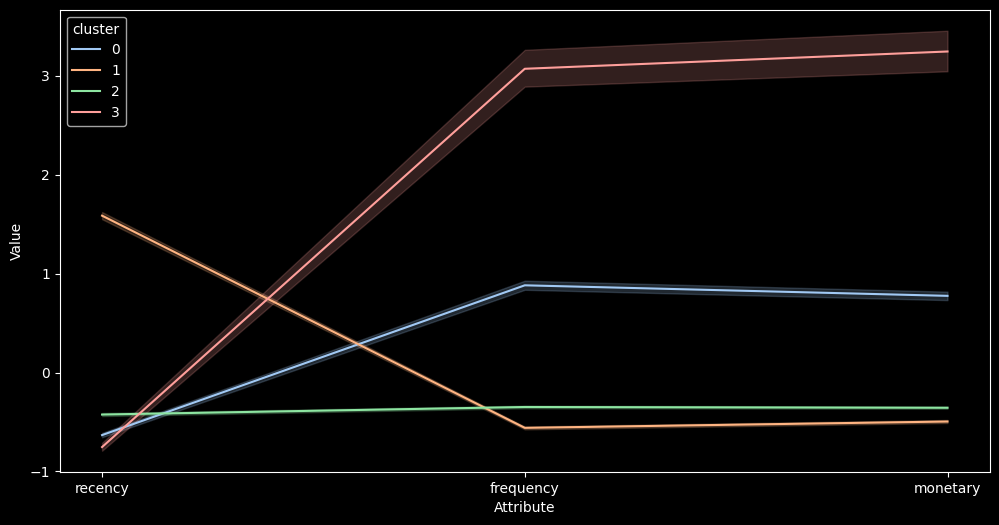

In [83]:
df_normalized = pd.DataFrame(df_kmeans_norm, columns = ['recency', 'frequency', 'monetary'])
df_normalized['id'] = kmeans_algorithm.index
df_normalized['cluster'] = model_clus4.labels_

# использовать функцию melt - преобразовать наши данныеиз широкого формата в длинный формат
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars = ['id', 'cluster'],
                      value_vars = ['recency', 'frequency', 'monetary'],
                      var_name = 'Attribute',
                      value_name = 'Value')

# устанавливаем размер фигуры
plt.figure(figsize = (12,6)) 

# cоздаем цветовую палитру
colors = sns.color_palette('pastel')

# строим lineplot
sns.lineplot(x = 'Attribute', y = 'Value', hue = 'cluster', data = df_nor_melt, palette = colors)

**Выводы:**

По результатам кластеризации KMeans были идентифицированы четыре различных сегмента клиентов:

- **Первый сегмент** (синяя линия) характеризуется очень низкой давностью, что указывает на то, что эти клиенты совершили покупки недавно, а также имеют высокую частоту и объем покупок. Этот сегмент, вероятно, представляет собой группу лояльных и ценных клиентов, которые постоянно совершают значительные покупки.

- **Второй сегмент** (оранжевая линия) имеет очень высокую давность, что указывает на то, что эти клиенты не совершали последних покупок, а также имеют очень низкую частоту и количество покупок. Это говорит о том, что они являются неактивными или устаревшими клиентами, которые в последнее время не взаимодействовали с компанией и совершили мало покупок на небольшую сумму.

- **Третий сегмент** (зеленая линия) характеризуется очень низкой давностью, что указывает на то, также имеют очень низкую частоту и количество покупок, а также имеют несколько более высокую частоту и объем покупок по сравнению со вторым сегментом. Этот сегмент, вероятно, представляет собой группу клиентов, которые в некоторой степени связаны с компанией, но не так активны и ценны, как клиенты в других сегментах.

- **Четвертый сегмент** (красная линия) характеризуется очень низкой давностью, что указывает на то, что эти клиенты совершили покупки недавно, а также имеют очень высокую частоту и объем покупок. Это говорит о том, что они являются частыми и ценными клиентами, активно сотрудничающими с компанией.

In [84]:
# подписываем все 4 кластера
kmeans_algorithm['cluster_n'] = kmeans_algorithm['cluster'].replace({0:'2-ое место Первый сегмент', 
                                                                     1:'4-ое место Второй сегмент', 
                                                                     2:'3-е место Третий сегмент', 
                                                                     3:'1-ое место Четвертый сегмент'})

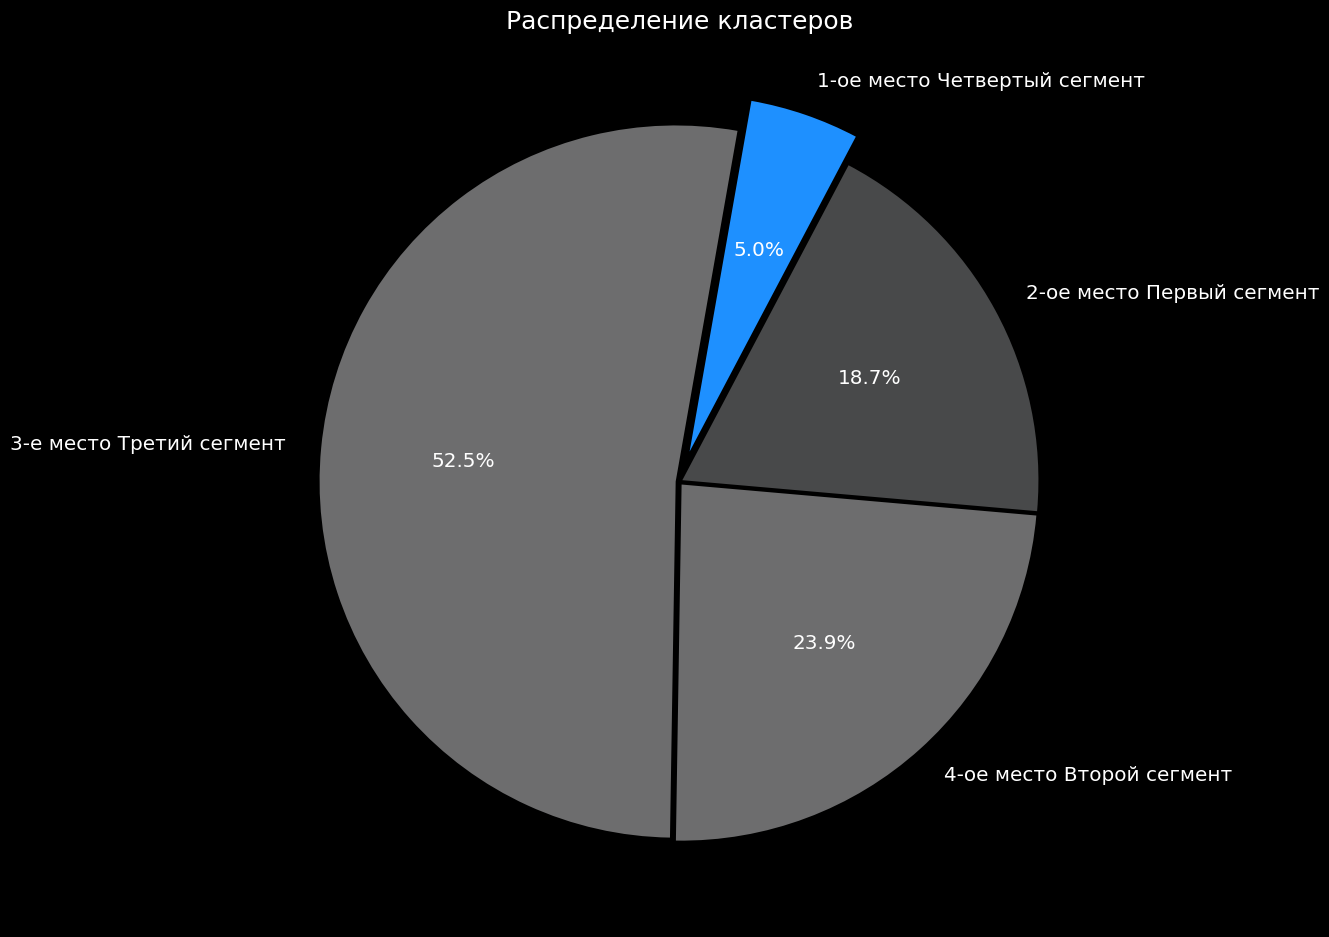

In [85]:
# устанавливаем размер фигуры
plt.subplots(figsize = (12, 10))

# создаем subject 
subject = kmeans_algorithm['cluster_n'].value_counts().reset_index(name = 'count')

# cоздаем цветовую палитру
colors = ['#6d6d6e', '#6d6d6e', '#48494a', '#1e90ff']

# строим pie
plt.pie(subject['count'], textprops = {'size': 'x-large'}, 
                                   labels = subject['cluster_n'], 
                                   autopct = '%1.1f%%', 
                                   radius = 1.0, 
                                   startangle = 80, 
                                   colors = colors,  
                                   explode = (0.01, 0.01, 0.01, 0.09))


plt.title('Распределение кластеров', size = 18)

plt.tight_layout()

Все кластеры разного размера.

Построим `boxplot` кластеров по количеству, давности и частоте.

**Monetary**

Text(0.5, 1.0, 'Monetary относительно кластеров')

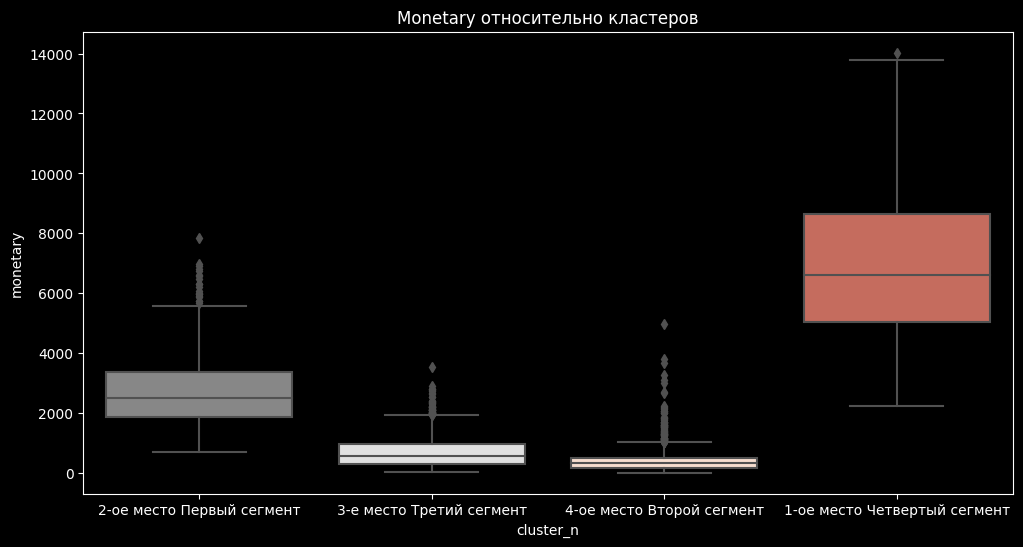

In [87]:
# устанавливаем размер фигуры
plt.figure(figsize = (12, 6))
    
# строим boxplot
ax = sns.boxplot(data = kmeans_algorithm, x = 'cluster_n', y= 'monetary', palette = 'RdGy_r')


# настройка графика 
plt.xlabel('cluster_n')
plt.ylabel('monetary')
plt.title('Monetary относительно кластеров')

**Frequency**

Text(0.5, 1.0, 'Frequency относительно кластеров')

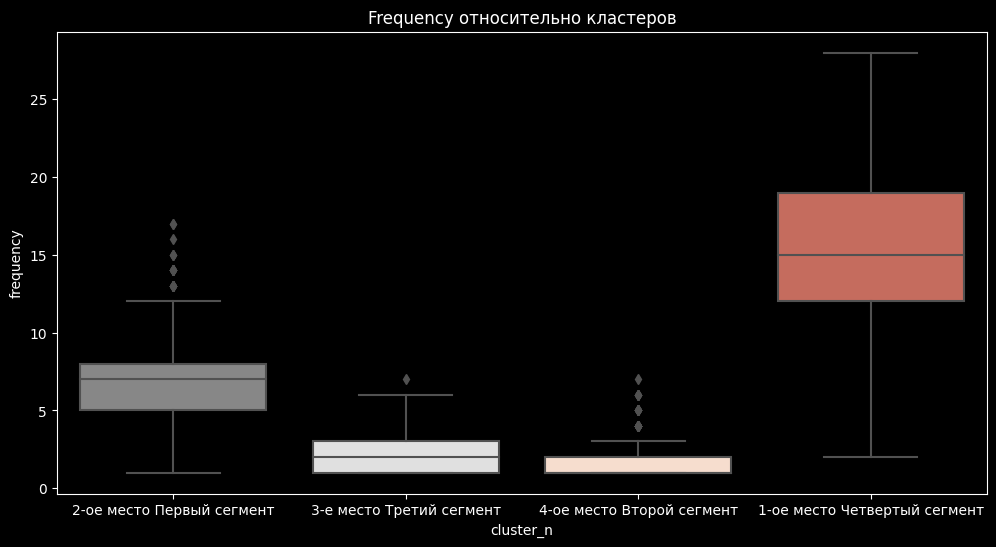

In [88]:
# устанавливаем размер фигуры
plt.figure(figsize = (12, 6))
    
# строим boxplot
ax = sns.boxplot(data = kmeans_algorithm, x = 'cluster_n', y = 'frequency', palette = 'RdGy_r')

# настройка графика 
plt.xlabel('cluster_n')
plt.ylabel('frequency')
plt.title('Frequency относительно кластеров')

**Recency**

Text(0.5, 1.0, 'Recency относительно кластеров')

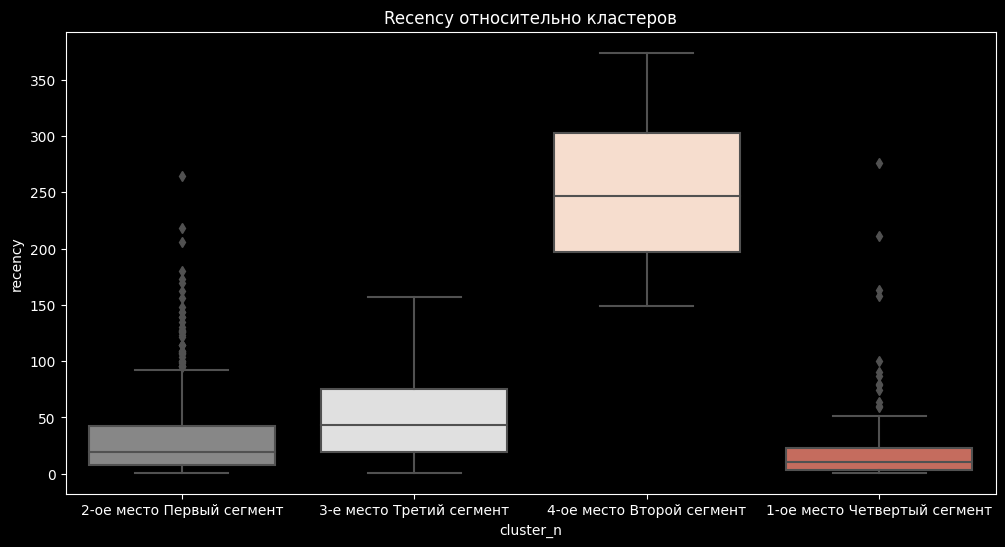

In [89]:
# устанавливаем размер фигуры
plt.figure(figsize = (12, 6))
    
# строим boxplot
ax = sns.boxplot(data = kmeans_algorithm, x = 'cluster_n', y = 'recency', palette = 'RdGy_r')

# настройка графика 
plt.xlabel('cluster_n')
plt.ylabel('recency')
plt.title('Recency относительно кластеров')

**Построим Pair plot**

Text(0.5, 1.05, 'Сравнение кластеров с recency, frequency, monetary')

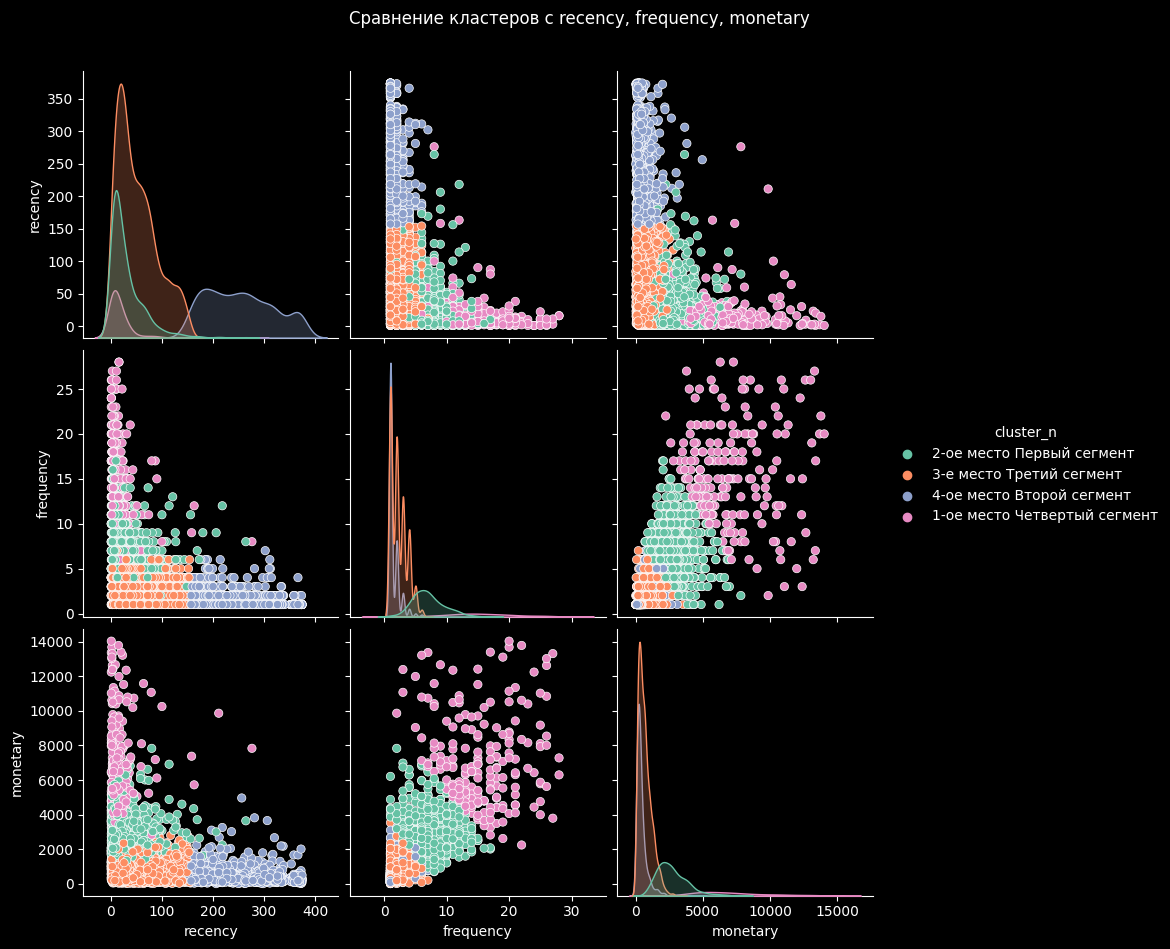

In [90]:
# строим график
sns.pairplot(kmeans_algorithm, hue = 'cluster_n', 
             vars = ['recency','frequency','monetary'],
             height = 3,
             aspect = 1,
             palette = 'Set2')

plt.suptitle('Сравнение кластеров с recency, frequency, monetary', y = 1.05)

**RFM в 3D с кластерами**

Text(0.5, 0.92, 'RFM в 3D с кластерами')

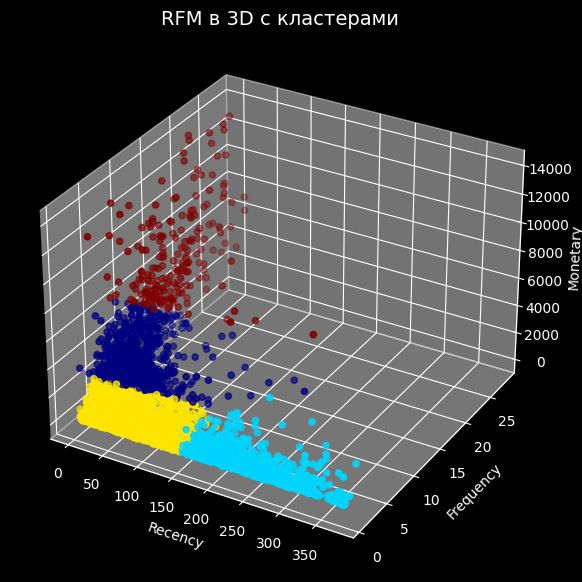

In [91]:
# устанавливаем размер фигуры
fig = plt.figure(figsize = (12, 7))
ax = plt.axes(projection = '3d')

# строим скатер3d
ax.scatter3D(kmeans_algorithm.recency,
             kmeans_algorithm.frequency, 
             kmeans_algorithm.monetary, 
             c = kmeans_algorithm.cluster, 
             cmap = 'jet')

# настройка графика
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('RFM в 3D с кластерами', size = 14)

**Выводы по алгоритму K-means:**

Довольно успешное применение кластеризации KMeans к набору данных для сегментации клиентов на основе их покупательского поведения. Определив отдельные сегменты клиентов, проект предоставил ценную информацию, которая может помочь в принятии стратегических решений и улучшить эффективность компании в сфере торговли. 

**Выявленные сегменты клиентов включают в себя:**

- **Ценные, частые клиенты:** Красные цвет - Четвертый сегмент

- **Высокоценные недавние клиенты:** Синий цвет - Первый сегмент

- **Недавние клиенты со средней ценностью:** Желтый цвет - Третий сегмент

- **Малоценные неактивные клиенты:** Бирюзовый цвет - Второй сегмент


В целом проект продемонстрировал силу сегментации клиентов и аналитических знаний в принятии стратегических решений и повышении эффективности бизнеса в сфере торговли. Понимая особые потребности и поведение различных сегментов клиентов, компания может адаптировать свои маркетинговые стратегии, оптимизировать управление запасами чтобы повысить лояльность и удовлетворенность клиентов.

### 9.2 Means Shift

**Кластеризация со средним сдвигом** - это неконтролируемый метод машинного обучения, позволяющий группировать похожие точки данных. Алгоритм среднего сдвига работает путем отнесения каждой точки данных к кластеру на основе плотности точек вокруг нее, а затем смещения каждой точки данных к среднему значению назначенного ей кластера.

Этот метод кластеризации может быть полезен для выявления кластеров данных, которые нелегко разделить с помощью других методов.

Как это работает алгоритм со средним сдвигом (**Means Shift**)?

1. Алгоритм Mean Shift работает путем отнесения каждой точки данных к кластеру.
2. Затем итеративного перемещения центроидов кластеров (`среднего` кластера) к среднему значению всех точек данных, отнесенных к этому кластеру, до тех пор, пока центроиды кластеров не перестанут перемещаться.
3. В результате получаются кластеры, в которых все точки данных более или менее `сдвинуты` к центроиду кластера.

**Когда следует использовать средний сдвиг?**

- Кластеризация со средним сдвигом не делает никаких предположений о форме распределения данных. Это делает ее очень гибким методом, который может адаптироваться к сложным, нелинейным распределениям данных.
- Кроме того, кластеризация со средним сдвигом не требует от пользователя указания количества кластеров, которые необходимо найти, что может быть полезно в ситуациях, когда количество кластеров заранее неизвестно.

- Однако важно отметить, что кластеризация со средним сдвигом не гарантирует, что она найдет глобальный оптимум для данного набора данных.

Примеры использования:

- Кластеризация со средним сдвигом может обнаружить кластеры любой формы, в отличие от K-средних, которые предрасположены к сферическим кластерам.

- Она устойчива к выбросам, поскольку основана на оценке плотности.

- Она автоматически определяет количество кластеров на основе данных.

- С другой стороны, она требует больших вычислительных затрат, чем K-means, особенно для больших наборов данных.

- Выбор пропускной способности может существенно повлиять на результаты, а найти оптимальную пропускную способность не так просто.

- Она плохо масштабируется с увеличением размерности данных.

- Средний сдвиг часто используется в обработке изображений для таких задач, как сегментация изображений и отслеживание объектов, а также в таких областях, как компьютерное зрение и анализ пространственных данных, где структура кластеров сложна и неизвестна.

**Преимущества и недостатки Means Shift**

Преимущества:

- Не нужно делать какие-либо модельные допущения, как в случае K-средних или гауссовой смеси.

- Он также может моделировать сложные кластеры, которые имеют невыпуклую форму.

- Там нет вопроса локальных минимумов, как в K-средних.

- Нет проблем, генерируемых выбросами.

Недостатки:

- Алгоритм среднего сдвига не работает хорошо в случае большой размерности, где количество кластеров резко меняется.

- Нет прямого контроля над количеством кластеров, но в некоторых приложениях нам нужно определенное количество кластеров.

- Он не может различить осмысленные и бессмысленные способы.

In [92]:
# создаем копию
meanshift_algorithm = rfm.copy()
meanshift_algorithm.head()

,recency,frequency,monetary
0,2,7,4310.00
1,75,4,1797.24
2,19,1,1757.55
3,310,1,334.40
4,36,8,2506.04


In [93]:
# стандартные переменные
standard_scaler = StandardScaler()
df_Meanshift_norm = standard_scaler.fit_transform(meanshift_algorithm)

In [94]:
# конвертируем в df
df_Meanshift_norm = pd.DataFrame(df_Meanshift_norm)
df_Meanshift_norm.columns = ['recency','frequency','monetary']
df_Meanshift_norm.head()

,recency,frequency,monetary
0,-0.917757,0.872736,1.678414
1,-0.188430,0.095626,0.271262
2,-0.747914,-0.681483,0.249036
3,2.159404,-0.681483,-0.547932
4,-0.578070,1.131773,0.668192


In [95]:
# модель
model_meanshift = MeanShift().fit(df_Meanshift_norm)

In [96]:
# метки
model_meanshift.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [97]:
meanshift_algorithm['clusters'] = model_meanshift.labels_
meanshift_algorithm.head()

,recency,frequency,monetary,clusters
0,2,7,4310.00,0
1,75,4,1797.24,0
2,19,1,1757.55,0
3,310,1,334.40,0
4,36,8,2506.04,0


In [98]:
meanshift_algorithm.groupby('clusters').agg({
                                            'recency':'mean',
                                            'frequency':'mean',
                                            'monetary':['mean', 'count']
                                            }).round(2)

recency frequency monetary      
            mean      mean     mean count
clusters                                 
0          96.79      3.16  1038.41  4090
1          10.12     20.79  7882.53    81
2          20.24     10.81  8154.91    72
3          98.56      5.33  6738.52    18

<Axes: xlabel='Attribute', ylabel='Value'>

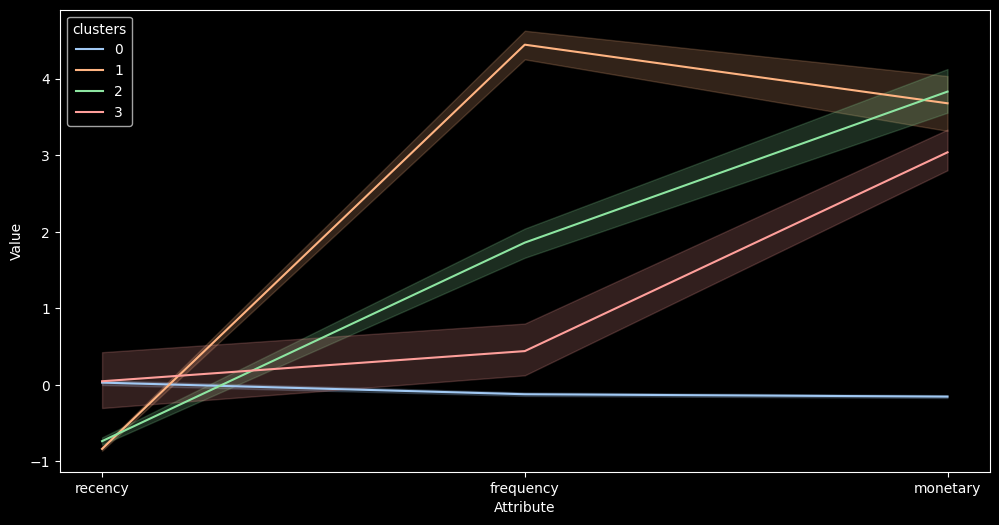

In [99]:
df_normalized_meanshift = pd.DataFrame(df_Meanshift_norm, columns = ['recency', 'frequency', 'monetary'])
df_normalized_meanshift['id'] = meanshift_algorithm.index
df_normalized_meanshift['clusters'] = model_meanshift.labels_

# использовать функцию melt - преобразовать наши данныеиз широкого формата в длинный формат
df_nor_melt_meanshift = pd.melt(df_normalized_meanshift.reset_index(),
                      id_vars = ['id', 'clusters'],
                      value_vars = ['recency', 'frequency', 'monetary'],
                      var_name = 'Attribute',
                      value_name = 'Value')

# устанавливаем размер фигуры
plt.figure(figsize = (12,6)) 

# cоздаем цветовую палитру
colors = sns.color_palette('pastel')

# строим lineplot
sns.lineplot(x = 'Attribute', y = 'Value', hue = 'clusters', data = df_nor_melt_meanshift, palette = colors)

**Выводы:**

По результатам кластеризации Means Shift были идентифицированы четыре различных сегмента клиентов:

- **Первый сегмент** (синяя линия) имеет очень высокую давность, что указывает на то, что эти клиенты не совершали последних покупок, а также имеют очень низкую частоту и количество покупок. Это говорит о том, что они являются неактивными или устаревшими клиентами, которые в последнее время не взаимодействовали с компанией и совершили мало покупок на небольшую сумму.

- **Второй сегмент** (оранжевая линия) и **Третий сегмент** (зеленая линия) почти одинаковы эти клиенты характеризуется очень низкой давностью, что указывает на то, что эти клиенты совершили покупки недавно, а также имеют очень высокую частоту и объем покупок. Это говорит о том, что они являются частыми и ценными клиентами, активно сотрудничающими с компанией.

- **Четвертый сегмент** (красная линия) имеет высокую актуальность и объем покупок, частоту выше минимальной, что указывает на то, что эти клиенты совершали недавние, частые и дорогостоящие покупки. Этот сегмент, вероятно, представляет собой группу лояльных и ценных клиентов, которые постоянно совершают значительные покупки.

In [100]:
# подписываем все 4 кластера
meanshift_algorithm['clusters_n'] = meanshift_algorithm['clusters'].replace({0:'4-ое место Первый сегмент', 
                                                                     1:'2-ое место Второй сегмент', 
                                                                     2:'1-ое место Третий сегмент', 
                                                                     3:'3-ое место Четвертый сегмент'})

Text(0.5, 1.0, 'Распределение кластеров')

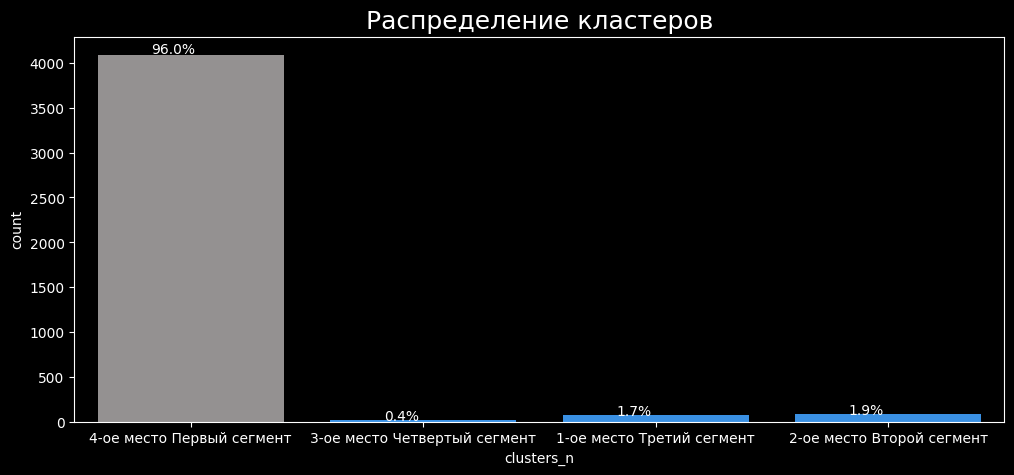

In [101]:
# устанавливаем размер фигуры
plt.figure(figsize = (12, 5))

# строим countplot
ax = sns.countplot(data = meanshift_algorithm, x = 'clusters_n', palette=['#949191', '#1e90ff', '#1e90ff', '#1e90ff'])

# возвращает количество элементов в списке
total = len(meanshift_algorithm.clusters_n)

# создаем цикл и рассчитываем для каждой колонки % количество сегментов
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 10)

# настройка графика
plt.title('Распределение кластеров', size = 18)

In [102]:
meanshift_algorithm

,recency,frequency,monetary,clusters,clusters_n
0,2,7,4310.00,0,4-ое место Первый сегмент
1,75,4,1797.24,0,4-ое место Первый сегмент
2,19,1,1757.55,0,4-ое место Первый сегмент
3,310,1,334.40,0,4-ое место Первый сегмент
4,36,8,2506.04,0,4-ое место Первый сегмент
...,...,...,...,...,...
4332,278,1,180.60,0,4-ое место Первый сегмент
4333,181,1,80.82,0,4-ое место Первый сегмент
4334,8,2,178.05,0,4-ое место Первый сегмент
4335,4,16,2045.53,0,4-ое место Первый сегмент


In [103]:
# удаляем колонку
meanshift_g = meanshift_algorithm.drop(columns = ['clusters', 'clusters_n'])

In [104]:
meanshift_g

,recency,frequency,monetary
0,2,7,4310.00
1,75,4,1797.24
2,19,1,1757.55
3,310,1,334.40
4,36,8,2506.04
...,...,...,...
4332,278,1,180.60
4333,181,1,80.82
4334,8,2,178.05
4335,4,16,2045.53


In [105]:
# определяем оценку силуэта
silhouette_meanshift = silhouette_score(meanshift_g, meanshift_algorithm['clusters'])
print(f'Для MeanShift, оценка силуэта : {silhouette_meanshift}')

Для MeanShift, оценка силуэта : 0.7250926437728389


**Построим Pair plot для Means Shift**

Text(0.5, 1.05, 'Сравнение кластеров с recency, frequency, monetary')

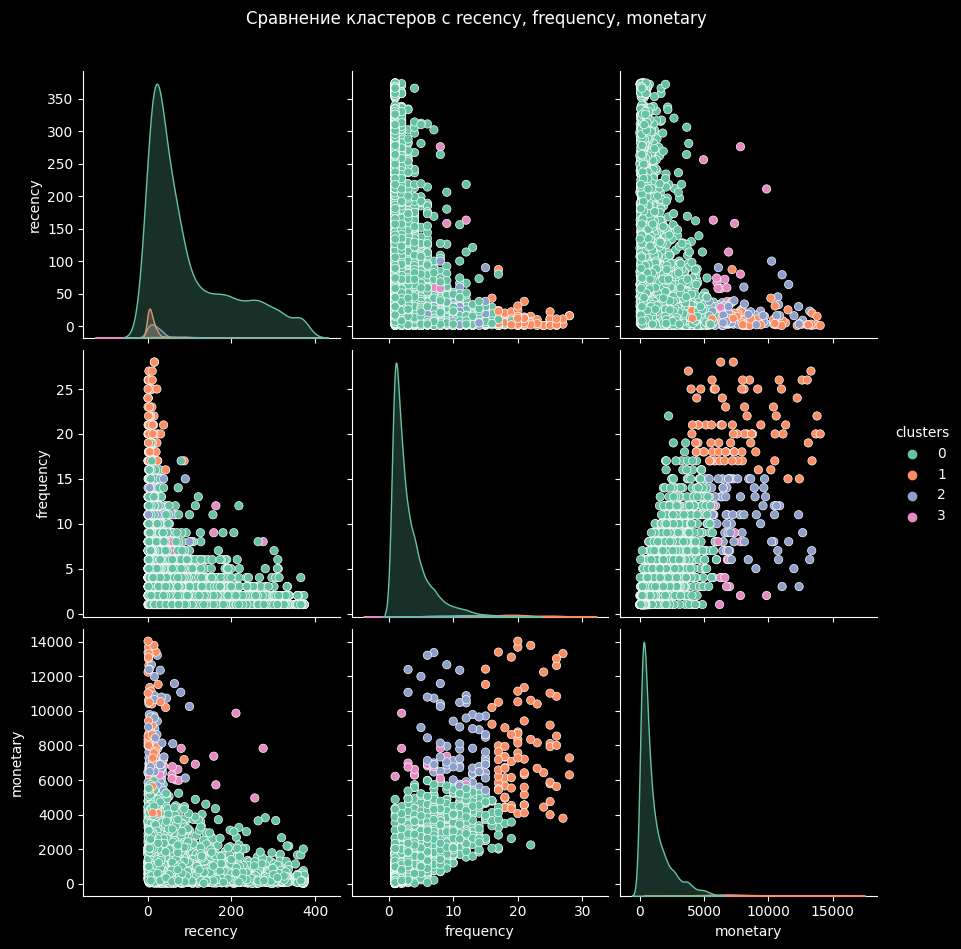

In [106]:
# строим график
sns.pairplot(meanshift_algorithm, hue = 'clusters', 
             vars = ['recency','frequency','monetary'],
             height = 3,
             aspect = 1,
             palette = 'Set2')

plt.suptitle('Сравнение кластеров с recency, frequency, monetary', y = 1.05)

**RFM в 3D с кластерами Mean Shift**

Text(0.5, 0.92, 'RFM в 3D с кластерами Mean Shift')

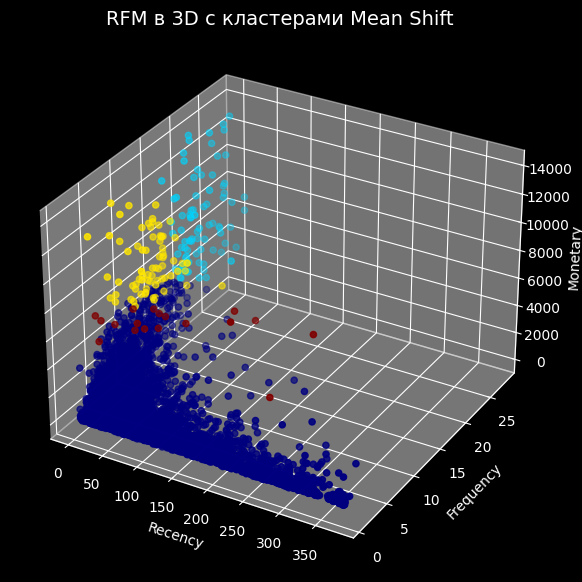

In [107]:
# устанавливаем размер фигуры
fig = plt.figure(figsize = (12, 7))
ax = plt.axes(projection ='3d')

# строим скатер3d
ax.scatter3D(meanshift_algorithm.recency, 
             meanshift_algorithm.frequency, 
             meanshift_algorithm.monetary, 
             c =  meanshift_algorithm.clusters, 
             cmap = 'jet')

# настройка графика
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('RFM в 3D с кластерами Mean Shift', size = 14)

### 9.3 Выводы по алгоритмам кластеризации

Можно сделать следующие выводы по нашим алгоритмам:

1. **K-means** - в целом продемонстрировал силу сегментации клиентов и аналитических знаний в принятии стратегических решений и повышении эффективности бизнеса.
2. **MeanShift** - несмотря на то что оценка силуэта ближе к 1 (0.7250926437728389), что говорит о лучшей разделяемости  кластеров, алгоритм выдал сильное неравномерное распределение данных. Поставим его на второе место и не будем использовать.

В целом, наши эксперименты показали, что **K-means** является наиболее подходящим методом для наших целей. Однако, всегда стоит помнить о возможности переобучения и важности проведения дополнительных тестов на новых данных